# ライブラリのインポート

In [1]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup
from urllib.request import urlopen
from itertools import combinations, permutations
import pandas as pd
import numpy as np
import datetime
import lightgbm as lgb
import requests
import time
import re
import optuna.integration.lightgbm as lgb_o
import matplotlib.pyplot as plt

# レース結果データ

In [2]:
results_df = pd.read_csv('race_results_sample100.csv', index_col=0)
results_df.head(2)

,着 順,枠 番,馬 番,馬名,性齢,斤量,騎手,タイム,着差,単勝,人 気,馬体重,調教師,course_len,weather,race_type,ground_state,date,horse_id,jockey_id
201001010101,1,8,10,マーベラスカイザー,牡2,54.0,古川吉洋,1:50.7,NaN,13.7,5.0,470(0),[西] 柴田政見,1800,晴,芝,良,2010年8月14日,2008100961,1015
201001010101,2,6,7,マイネルヴァルム,牡2,54.0,丹内祐次,1:50.9,1.1/2,7.6,4.0,438(+16),[東] 畠山重則,1800,晴,芝,良,2010年8月14日,2008104484,1091


# 馬の血統データ

In [3]:
# peds_df = pd.read_csv('peds.csv', index_col=0)
# peds_df.head(2)

# 各馬の過去の戦績データ

In [4]:
# horse_results_df = pd.read_csv('horse_results.csv', index_col=0)
# horse_results_df.head(2)

# 払い戻しデータ

In [5]:
# returns_df = pd.read_csv('returns_df.csv', index_col=0)
# returns_df.head(2)

# 前処理

In [6]:
results_df['着 順'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '取', '11(降)', '14', '15', '16', '中', '失', '除', '12(降)'],
      dtype=object)

In [7]:
# 文字列が入っているものをNoneに処理
results_df['着順'] = pd.to_numeric(results_df['着 順'], errors='coerce')
# 着順に欠損値が存在する行を削除
results_df.dropna(subset=['着順'], inplace=True)
results_df['着順'] = results_df['着順'].astype(int)
# 3位以内に入るかどうかを表す列を追加（目的変数予定）
results_df['rank'] =results_df['着順'].map(lambda x: 1 if x<4 else 0)

In [8]:
# 性齢を性と齢に分ける
results_df['性'] = results_df['性齢'].map(lambda x: str(x)[0])
results_df['齢'] = results_df['性齢'].map(lambda x: str(x)[1:]).astype(int)

In [9]:
# 馬の体重を体重と体重変化に分ける
results_df['体重'] = results_df['馬体重'].str.split('(', expand=True)[0]
results_df['体重変化'] = results_df['馬体重'].str.split("(", expand=True)[1].str[:-1]

In [10]:
# 数値型にする
results_df['体重'] = pd.to_numeric(results_df['体重'], errors='coerce')
results_df['体重変化'] = pd.to_numeric(results_df['体重変化'], errors='coerce')

In [11]:
# float型に変換
results_df['単勝'] = results_df['単勝'].astype(float)

In [12]:
# 桁数を少なくする
results_df['course_len'] = results_df['course_len'].astype(float) // 100

In [13]:
# dateを日付型に
results_df["date"] = pd.to_datetime(results_df["date"], format="%Y年%m月%d日")

In [14]:
#開催場所（race_idの5番目と6番目の文字）
results_df['開催'] = results_df.index.map(lambda x:str(x)[4:6])        

In [15]:
# 走る馬の数をレース毎に追加
results_df['n_horses'] = results_df.index.map(results_df.index.value_counts())

In [16]:
results_df.head(1)

,着 順,枠 番,馬 番,馬名,性齢,斤量,騎手,タイム,着差,単勝,...,horse_id,jockey_id,着順,rank,性,齢,体重,体重変化,開催,n_horses
201001010101,1,8,10,マーベラスカイザー,牡2,54.0,古川吉洋,1:50.7,NaN,13.7,...,2008100961,1015,1,1,牡,2,470,0,01,11


In [17]:
# 予測する際にリークとなるカラム or 不要なカラムを削除
results_df.drop(["タイム", "着差", "調教師", "性齢", "馬体重", '馬名', '騎手', '人 気', '着順', '着 順'], axis=1, inplace=True)

In [18]:
results_df

,枠 番,馬 番,斤量,単勝,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,rank,性,齢,体重,体重変化,開催,n_horses
201001010101,8,10,54.0,13.7,18.0,晴,芝,良,2010-08-14,2008100961,1015,1,牡,2,470,0,01,11
201001010101,6,7,54.0,7.6,18.0,晴,芝,良,2010-08-14,2008104484,1091,1,牡,2,438,16,01,11
201001010101,1,1,54.0,16.3,18.0,晴,芝,良,2010-08-14,2008101585,1019,1,牡,2,482,-2,01,11
201001010101,4,4,54.0,53.1,18.0,晴,芝,良,2010-08-14,2008104312,1093,0,牡,2,470,0,01,11
201001010101,7,9,54.0,2.0,18.0,晴,芝,良,2010-08-14,2008102020,5135,0,牝,2,412,-6,01,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201001010812,4,6,57.0,14.1,18.0,曇,芝,良,2010-09-05,2005106725,1015,0,牡,5,502,-8,01,13
201001010812,6,10,57.0,123.2,18.0,曇,芝,良,2010-09-05,2003102078,1096,0,牡,7,466,12,01,13
201001010812,5,7,52.0,7.5,18.0,曇,芝,良,2010-09-05,2007101659,1032,0,牝,3,486,32,01,13
201001010812,6,9,55.0,105.0,18.0,曇,芝,良,2010-09-05,2005100882,1095,0,牝,5,454,8,01,13


In [19]:
results_df['jockey_label'] = LabelEncoder().fit(results_df['jockey_id']).transform(results_df['jockey_id'])
results_df['horse_label'] = LabelEncoder().fit(results_df['horse_id']).transform(results_df['horse_id'])
results_df['jockey_label'] = results_df['jockey_label'].astype('category')
results_df['horse_label'] = results_df['horse_label'].astype('category')

In [20]:
# カテゴリ変数
weathers = results_df['weather'].unique()
race_types = results_df['race_type'].unique()
ground_states = results_df['ground_state'].unique()
sexes = results_df['性'].unique()
results_df['weather'] = pd.Categorical(results_df['weather'], weathers)
results_df['race_type'] = pd.Categorical(results_df['race_type'], race_types)
results_df['ground_state'] = pd.Categorical(results_df['ground_state'], ground_states)
results_df['性'] = pd.Categorical(results_df['性'], sexes)
results_df = pd.get_dummies(results_df, columns=['weather', 'race_type', 'ground_state', '性'])

# 馬の血統データが揃っている時

In [21]:
# 血統のテーブルの処理
# for column in ped_df.columns:
#     peds_df[column] = LabelEncoder().fit_transform(peds_df[column].fillna('Na'))
# peds_df = peds_df.astype('category')

In [22]:
# peds_df.head(2)

In [23]:
# ジョインさせる過去５世代の血統を抜き出す
# peds_5_df = peds_df[['peds_0', 'peds_1', 'peds_2', 'peds_3', 'peds_4']]
# peds_5_df.head(2)

In [24]:
# results_df = results_df.join(peds_5_df, how='left', on=['horse_id'])

# 各馬の過去の戦績データが揃っている時

この部分のデータを追加したい

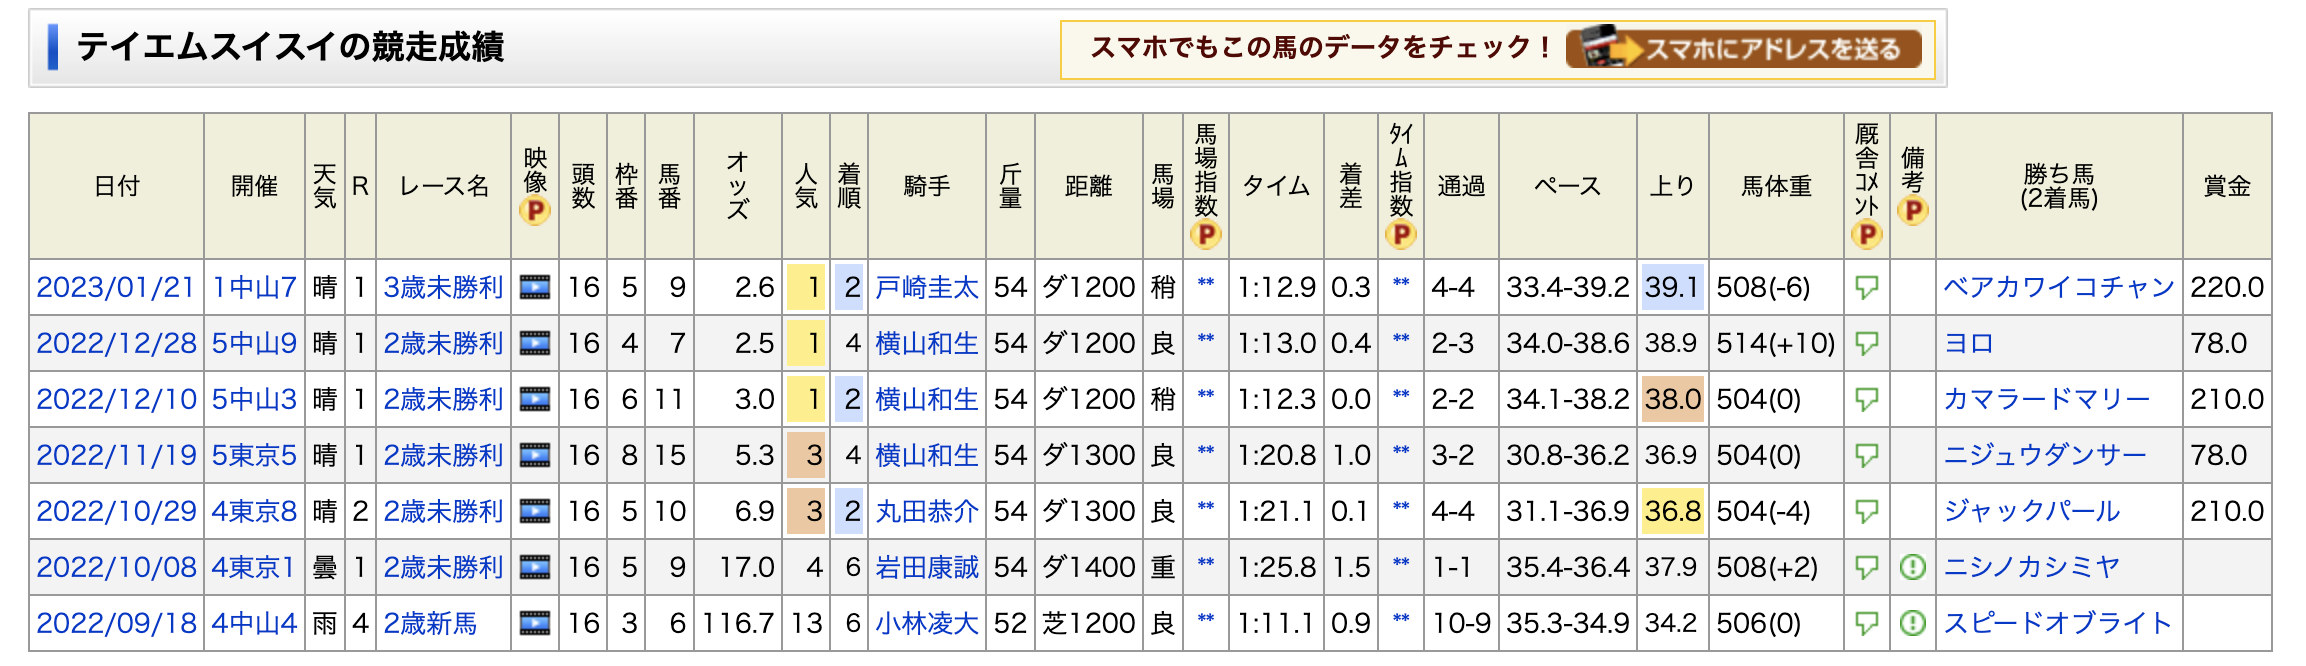

# 前処理完了

In [25]:
results_df.to_csv('preprocessed_df.csv')